In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import h5py
import copy
from scipy.optimize import curve_fit


# In[2]:


class Sig:
    def __init__(self):
        self.number_groups = 0
        self.sig_f = []
        self.capture = []
        self.scattering = []
        self.total = []
        self.number_of_production_neutrons = []
        self.c_value = []
        self.virtual = []
        
    def __init__(self, number_groups, sig_f, sig_c, sig_s, number_of_production_neutrons, sig_t, anisotropic = []):
        self.number_groups = number_groups
        self.sig_f = sig_f
        self.sig_c = sig_c
        self.sig_s = sig_s      
        self.number_of_production_neutrons = number_of_production_neutrons
        self.sig_t = sig_t
        self.delta_xs = max(sig_t)/2.
        max_total_cs = max(self.sig_t)
        self.virtual = [self.delta_xs]
        self.anisotropic = anisotropic
        
               
    def get_virtual_cs(self):
        max_total_cs = max(self.sig_t)
        self.virtual = [cross_section - max_total_cs + self.delta_xs for cross_section in self.sig_t]
        
    def return_virtual(self):
        return self.virtual
        
    def get_fission_probability(self, energy_group_idx):
        return self.sig_f[energy_group_idx] / self.sig_t[energy_group_idx]
    
    def get_capture_probability(self, energy_group_idx):
        return self.sig_c[energy_group_idx] / self.sig_t[energy_group_idx]
        
    def get_scatter_probability(self, energy_group_idx):
        return self.sig_s[energy_group_idx] / self.sig_t[energy_group_idx]
    
    def get_anisotropic(self, energy_group_idx):
        return self.anisotropic[energy_group_idx]
        
        


# In[3]:


energy_groups_2 = [0, 2 * 1E10]

class Positon:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
class Direction:
    def __init__(self, ets, phi):
        self.tetta_x = math.sin(ets) * math.cos(phi)
        self.tetta_y = math.sin(ets) * math.sin(phi)
        self.tetta_z = math.cos(ets)  


# In[4]:


class Particle:
    def __init__(self):
        self.coordinates = Positon(0, 0, 0)
        self.direction = Direction(0, 0)
        self.energy = 0
        self.weight = 1
        self.energy_groups = []
        self.terminated = False
        self.path = 0.
        self.last_cell = 0
        
    def set_coordinates(self, x, y, z):
        self.coordinates = Positon(x, y, z)
        
    def set_direction(self, ets, phi):
        self.direction = Direction(ets, phi)
    
    def set_direction_angle(self, angle):
        self.direction = angle
        
    def set_energy_groups(self, energy_groups):
        self.energy_groups = energy_groups
        
    def get_energy_group(self):  
        res = next(x for x, val in enumerate(self.energy_groups)
                                  if val > self.energy)        
        return res - 1
    
    def set_terminated(self):
        self.terminated = True
        
    def is_terminated(self):
        return self.terminated
        
    def get_weight(self):
        return self.weight
    
    def set_weight(self, weight):
        self.weight = weight
    
    def set_particle_deleted(self):
        self.weight = self.weight * 0
        
    def set_particle_fission(self, additional_weight):
        self.weight = self.weight * additional_weight
        
    def set_multiplicity(self, additional_weight):
        self.weight = self.weight * additional_weight
              
    def is_particle_deleted(self):
        return self.weight < 0.0001
    
    def add_path(self, path):
        self.path += path
    
    def get_path(self):
        return self.path
    
    def set_path(self, path):
        self.path = path
        
    def print_direction(self):
        print(str(self.direction.tetta_x) + " " + str(self.direction.tetta_y) + " " + str(self.direction.tetta_z))
        
    def print_coordinates(self):
        print(str(self.coordinates.x) + "  " + str(self.coordinates.y) + " " + str(self.coordinates.z))  
        


# In[5]:


class Plane:
    def __init__(self, A, B, C, D):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        
    def distance(self, particle):
        vp = (self.A * particle.direction.tetta_x + self.B * particle.direction.tetta_y + 
              self.C * particle.direction.tetta_z)
        
        
        if (abs(vp) < 1e-9):
            return -1
        
        distance = (self.D - self.A * particle.coordinates.x - self.B * particle.coordinates.y 
                    - self.C * particle.coordinates.z) / vp
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    

    def get_sign(self, particle):
      
        sign = (self.A * particle.coordinates.x + self.B * particle.coordinates.y +
        self.C * particle.coordinates.z - self.D)
        
        if sign == 0:
            return sign    
            
        if sign < 0:
            return -1
        else:
            return 1
        
    def get_xml(self):
        
        obj_xml = " Plane with A "+ str(self.A) + " B "+ str(self.B) + " C "+ str(self.C) + " D "+ str(self.D)
        
        return obj_xml
    


# In[6]:


class Universe:
    def __init__(self, cells, xs):
        self.cells = cells
        self.xs = xs
        self.delta_xs = 0.
        
    def calculate_delta_xs(self):
        
        delta_xs = 0.
        for xs in self.xs:
            delta_xs = max(delta_xs, max(xs.sig_t))
        self.delta_xs = delta_xs           
            
    def get_delta_xs(self):
        
        return self.delta_xs
    
    def get_xs_by_coordinates(self, particle):
        
        for i in range(0, len(cells)):
            cell = cells[i]
            if cell.is_inside(particle):
                particle.last_cell = i
                return self.xs[i]
        return []
    
    def is_inside(self, particle):
        
        for cell in self.cells:
            if cell.is_inside(particle):
                return True
        return False
        
    
    def is_boudary_reflective(self, particle):
        
        minumum = np.inf
        idx_of_min = 0.
        for i in range(0, len(self.cells)):
            distance, surface_idx = self.cells[i].get_minimum_distance(particle)
            if abs(distance) < minumum:
                minumum = distance
                idx_of_min = i
        if self.cells[idx_of_min].is_boudary_reflective(particle):
            return True
        else:
            return False
        
    def reflect_particle(self,  particle):
        self.cells[particle.last_cell].reflect_particle(particle)       


# In[7]:


def set_random_direction(particle):
    r = 1.0
    r1 = 1.0
    while (r**2 + r1**2 > 1.0):
        r = 2. * random.uniform(0, 1) - 1.
        r1 = 2. * random.uniform(0, 1) - 1.
        
    direction_x = 2.0 * r**2 + 2. * r1**2 - 1.0  
    particle.direction.tetta_z = direction_x
    particle.direction.tetta_y = r * math.sqrt((1.0 - direction_x**2)/(r**2+r1**2))
    particle.direction.tetta_x = r1 * math.sqrt((1.0 - direction_x**2)/(r**2+r1**2))
    
    if (particle.direction.tetta_z * particle.direction.tetta_z + 
    particle.direction.tetta_y * particle.direction.tetta_y + 
    particle.direction.tetta_x * particle.direction.tetta_x > 1.01):
        print("dir_x * dir_x + dir_y * dir_y + dir_z * dir_z")
        print(dir_x * dir_x + dir_y * dir_y + dir_z * dir_z)
    

In [56]:
## Infinite cylinder parallel to z-axis

class ZCylinder:
    def __init__(self, x_0, y_0, r):
        self.x_0 = y_0
        self.y_0 = y_0
        self.r = r
        
    def distance(self, particle):
    
        a_ = particle.direction.tetta_x * particle.direction.tetta_x + (particle.direction.tetta_y * particle.direction.tetta_y)
        
        ## If a=0a 0a=0, this means the particle is parallel to the cylinder and will thus never intersect it
        if (abs(a_) < 1e-9):
            return -1
        
        c_ = ((particle.coordinates.x - self.x_0) * (particle.coordinates.x - self.x_0) + 
              (particle.coordinates.y - self.y_0) * (particle.coordinates.y - self.y_0) - self.r * self.r)

        k_ = (particle.coordinates.x -self.x_0) * particle.direction.tetta_x +(particle.coordinates.y -self.y_0) * particle.direction.tetta_y
        
        dec = k_ * k_ - a_ * c_
        
        if dec < 0:
            return -1
        
        dist_1 = (-k_ + math.sqrt(k_ * k_ - a_ * c_))/a_
        dist_2 = (-k_ - math.sqrt(k_ * k_ - a_ * c_))/a_
         
        distance = min(dist_1, dist_2)
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    
    def get_reflected_direction(self, angle):
        
        eps = random.uniform(0, math.pi * 2)
        tetta = random.uniform(0, math.pi)
        r_reflected = Direction(eps, tetta)
        
        return r_reflected  
    
    def get_sign(self, particle):
            
        sign = ((self.x_0 - particle.coordinates.x) * (self.x_0 - particle.coordinates.x) + 
        (self.y_0 - particle.coordinates.y) * (self.y_0 - particle.coordinates.y) - self.r * self.r)
        
        if sign == 0:
            return 0
            
        if sign < 0:
            return -1
        else:
            return 1
        
        
    def get_xml(self):

        obj_xml = " ZCylinder with x_0 "+ str(x_0) + " y_0 "+ str(y_0) + " r = "+ str(r) 
        
        return obj_xml

In [57]:
def calculate_mu_4(anisotropic_coeffs):
    random.seed(time.time())
    
    a = (3/2 - 3/2 * (anisotropic_coeffs[1] / anisotropic_coeffs[0]))
    
    rand = random.uniform(0, 1)
    old_mu = 2. * math.sqrt(rand) - 1.
    f_mu = (1 + old_mu)/2.
    delta = 1
        
    mu = a * f_mu + (1 - a) * delta       
        
    return mu 

In [58]:
def calculate_mu_dirac(anisotropic_coeffs):
    random.seed(time.time())
    
    rand = random.uniform(0, 1)
    
    mu = 0
    if rand <= (1 - anisotropic_coeffs[1] / anisotropic_coeffs[0]):
        fi = random.uniform(0, 1)
        mu = 2 * fi - 1
    else:
        mu = 1
        
    return mu 

In [59]:
def calculate_mu(anisotropic_coeffs):
    
    random.seed(time.time())
    
    b = 3. * anisotropic_coeffs[1] / anisotropic_coeffs[0]
    gamma =  random.uniform(0, 1)
    sqr = (1/2 - b)**2 + 2 * b * gamma
    

    result_mu1 = (-1/2 + math.sqrt(sqr))/b
    result_mu2 = (-1/2 - math.sqrt(sqr))/b
    if abs(result_mu1) < 1:
        return result_mu1
    
    if abs(result_mu2) < 1:
        return result_mu2
    
    
    return anisotropic_coeffs[1] / anisotropic_coeffs[0]

In [60]:
def get_anisotropic_direction(particle, mu):
    r = 1.0
    r1 = 1.0
    while (r**2 + r1**2 > 1.0):
        r = 2. * random.uniform(0, 1) - 1.
        r1 = 2. * random.uniform(0, 1) - 1.
    
    dir_x = particle.direction.tetta_x
    dir_y = particle.direction.tetta_y
    dir_z = particle.direction.tetta_z
    rr1 = math.sqrt(r**2 + r1**2)
    rmr1 = math.sqrt(1. - dir_z**2)
    mu_1 = math.sqrt(1. - mu**2)
    
    dir_x_tmp = dir_x * mu + mu_1 * (r * dir_x * dir_z - r1 * dir_y) / rr1 / rmr1
    dir_y_tmp = dir_y * mu + mu_1 * (r * dir_y * dir_z + r1 * dir_x) / rr1 / rmr1
    dir_z_tmp = dir_z * mu - mu_1 * r* rmr1 /rr1
    particle.direction.tetta_x = dir_x_tmp
    particle.direction.tetta_y = dir_y_tmp
    particle.direction.tetta_z = dir_z_tmp
  #  dir_y = dir_y_tmp
   # dir_z = dir_z_tmp
    
    

In [70]:
def get_anisotropic_direction_2(particle, mu):
    
    
    dir_x = particle.direction.tetta_x
    dir_y = particle.direction.tetta_y
    dir_z = particle.direction.tetta_z
    
    b = math.sqrt(1 - mu * mu)
    ro = math.sqrt(1 - dir_z * dir_z)
    phi = random.uniform(-math.pi, math.pi)

    c = math.cos(phi)
    d = math.sin(phi)
    a = mu
    
    dir_x_tmp = (b * c * dir_x * dir_z)/ro  - (b * d * dir_y)/ro + a * dir_x    
    dir_y_tmp = (b * c * dir_y * dir_z)/ro  + (b * d * dir_x)/ro + a * dir_y  
    dir_z_tmp = -b * c * ro  + a * dir_z
    
    particle.direction.tetta_x = dir_x_tmp
    particle.direction.tetta_y = dir_y_tmp
    particle.direction.tetta_z = dir_z_tmp
    
    
    

In [113]:
def get_anisotropic_direction_3(particle, mu):
    
    
    dir_x = particle.direction.tetta_x
    dir_y = particle.direction.tetta_y
    dir_z = particle.direction.tetta_z
    a = mu
    b = math.sqrt(1. - mu * mu)
    
    r = 1.5
    r1 = 1.5
    while (r**2 + r1**2 > 1.0):
        r = 2. * random.uniform(0, 1) - 1.
        r1 = 2. * random.uniform(0, 1) - 1.
        
    cos_phi = r1/ math.sqrt(r *r + r1 * r1)
    sin_phi = r/ math.sqrt(r *r + r1 * r1)
    
    c = cos_phi
    d = sin_phi
    
    
    ro = math.sqrt(1. - dir_z * dir_z)
    
    dir_x_tmp = (b * c * dir_x * dir_z) / ro - (b * d * dir_y) / ro + a * dir_x
    dir_y_tmp = (b * c * dir_y * dir_z) / ro + (b * d * dir_x) / ro + a * dir_y
    dir_z_tmp = -b * c * math.sqrt(1. - dir_z * dir_z) + a * dir_z
    

    particle.direction.tetta_x = dir_x_tmp
    particle.direction.tetta_y = dir_y_tmp
    particle.direction.tetta_z = dir_z_tmp
    
  #  print
    
    

In [114]:
def set_random_direction_anisotropic(particle, xs, border):
  #  set_random_direction(particle)
    
    energy_group_idx = particle.get_energy_group()
    anisotropic_coeffs = xs.get_anisotropic(energy_group_idx)   
    random.seed(time.time())
    mu = calculate_mu(anisotropic_coeffs)


    dir_x_before = particle.direction.tetta_x
    dir_y_before = particle.direction.tetta_y
    dir_z_before = particle.direction.tetta_z

    
    get_anisotropic_direction_3(particle, mu)
        

    dir_x_after = particle.direction.tetta_x
    dir_y_after = particle.direction.tetta_y
    dir_z_after = particle.direction.tetta_z
    
    dot = dir_x_before * dir_x_after + dir_y_before * dir_y_after + dir_z_before * dir_z_after
    
    x_len = math.sqrt(dir_x_before * dir_x_before + dir_y_before * dir_y_before + dir_z_before * dir_z_before)
    y_len = math.sqrt(dir_x_after * dir_x_after + dir_y_after * dir_y_after + dir_z_after * dir_z_after)
    
    mult = dot /(x_len * y_len)
  #  if abs(mu - mult) > 0.00001:
   #     print(mu)
    #    print(mult)
     #   print("error")
    #    assert(False)

    
    sum_sq = (particle.direction.tetta_z * particle.direction.tetta_z + 
    particle.direction.tetta_y * particle.direction.tetta_y + 
    particle.direction.tetta_x * particle.direction.tetta_x)
    
    
  #  if (sum_sq > 1.01):
   #     print("sum sq "+ str(sum_sq))
        

In [148]:

# In[8]:


import random

def make_initial_sources(number_of_paricles, box_size, zero_point, energy=10.0e6):
    
    step_x = box_size[0]/number_of_paricles
    step_y = box_size[1]/number_of_paricles
    step_z = box_size[2]/number_of_paricles
    
    x_coord = zero_point[0]
    y_coord = zero_point[1]
    z_coord = zero_point[2]
    
    sources = []
    for i in range(0, number_of_paricles):
        for j in range(0, number_of_paricles):
            for k in range(0, number_of_paricles):
                current_particle = Particle()
                current_particle.set_coordinates(x_coord + k * step_x, y_coord + j * step_y, z_coord+ i * step_z)
                set_random_direction(current_particle)
                current_particle.energy = energy
                current_particle.set_energy_groups(energy_groups_2)
                sources.append(current_particle)

    return sources


# In[9]:


def get_free_path(particle, delta_xs):
    
    energy_group_idx = particle.get_energy_group()   
    sig_t = delta_xs
    free_path = -math.log(random.uniform(0, 1)) / sig_t
    
    return free_path  


# In[10]:


class Cell:
    def __init__(self):
        self.surfaces = []
        self.boundaries_type = []
        self.signs = []
        self.size = 0
        
    def set_boundaries_type(self, boundaries_type):
        self.boundaries_type = boundaries_type        
        
    def set_box_sizes(self, xm_size, ym_size, zm_size, x_size, y_size, z_size):
        self.xm_size = xm_size
        self.ym_size = ym_size
        self.zm_size = zm_size
        
        self.x_size = x_size
        self.y_size = y_size
        self.z_size = z_size
        
    def set_zero_point(self, x_0, y_0, z_0):
        self.x_0 = x_0
        self.y_0 = y_0
        self.z_0 = z_0
        
    def __init__(self, surfaces, signs):
        self.surfaces = surfaces
        self.signs = signs
        self.size = len(self.signs)
           
    def is_inside(self, particle):
        
        is_inside = True
        for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
                is_inside = False
                
        return is_inside
    
    def is_boudary_reflective(self, particle):
        for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
                if self.boundaries_type[i] == 'reflective':
                    return True
                else:
                    return False
        
    
    def get_minimum_distance(self, particle):
        
        minimum_distance = math.inf
        surface_idx = 0
        for i in range(0, len(self.surfaces)):
            current_distance = abs(self.surfaces[i].distance(particle))
            if current_distance > 0:
                minimum_distance = min(minimum_distance, current_distance)
                surface_idx = i
        return minimum_distance, surface_idx
    
    def get_xml(self):
        
        xml_obj = []
        for i in range(0, self.size):
            xml_obj.append(surfaces[i].get_xml())
            
        return xml_obj
    
    def reflect_particle(self, particle):
        
        if particle.coordinates.x > (self.x_size + self.x_0):
            delta = particle.coordinates.x % self.x_size
            particle.coordinates.x = self.xm_size + math.fabs(delta)
        
        if particle.coordinates.y > (self.y_size + self.y_0):
            
            delta = particle.coordinates.y % self.y_size
            particle.coordinates.y = self.ym_size + math.fabs(delta)
            
            
        if particle.coordinates.z > (self.z_size + self.z_0):
            
            delta = particle.coordinates.z % self.z_size
            particle.coordinates.z = self.zm_size + math.fabs(delta)
        
        
        if particle.coordinates.y < (self.ym_size + self.y_0):
            delta = particle.coordinates.y % self.ym_size
            particle.coordinates.y = self.y_size - math.fabs(delta)
            
            
        if particle.coordinates.x < (self.xm_size + self.x_0):
            delta = particle.coordinates.x % self.xm_size
            particle.coordinates.x = self.x_size - math.fabs(delta)
            
        if particle.coordinates.z < (self.zm_size + self.z_0):
            delta = particle.coordinates.z % self.zm_size
            particle.coordinates.z = self.z_size - math.fabs(delta)
                    


# In[11]:


def move_particle(particle, t):
    new_x = particle.direction.tetta_x * t + particle.coordinates.x
    new_y = particle.direction.tetta_y * t + particle.coordinates.y
    new_z = particle.direction.tetta_z * t + particle.coordinates.z
    particle.set_coordinates(new_x, new_y, new_z)


# In[13]:


def is_collision_virual(particle, c_s, delta_xs):
    
    energy_group_idx = particle.get_energy_group()
    random_number = random.uniform(0, 1)
    
    virtual_cs = delta_xs
    
    total_cs = c_s.sig_t[energy_group_idx]
    
    if total_cs/virtual_cs < random_number:
        return True
    else:
        return False


# In[14]:


def process_virtual_collision(particle, free_path):
    particle.add_path(free_path)
    print("process_virtual_collisions")



def process_real_collision(particle, free_path, c_s):
    
    energy_group_idx = particle.get_energy_group()
    weight_before_collision = particle.get_weight()
    number_of_production_neutrons = c_s.number_of_production_neutrons[energy_group_idx]   
    capture_probability = c_s.get_capture_probability(energy_group_idx)
    scatter_probability = c_s.get_scatter_probability(energy_group_idx)  
    fission_probability = c_s.get_fission_probability(energy_group_idx)  
    
    
    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                            fission_probability])
    if type_collision == 'capture':
        particle.set_terminated()
        set_random_direction(particle)
        particle.set_weight(0.)
        
    if type_collision == 'scatter':
       # set_random_direction(particle)
        set_random_direction_anisotropic(particle, c_s, 1/3)
        
        
    if type_collision == 'fission':    
        particle.set_particle_fission(number_of_production_neutrons)
        set_random_direction(particle)
        particle.set_terminated()
        
    return weight_before_collision


# In[16]:


def delete_absorpbed_paricles(particles):
    
    existing_particles = []
    for i in range(0, len(particles)):
        particle = particles[i]
        if particle.get_weight() > 0.000001:
            existing_particles.append(particle)
                     
    return existing_particles


# In[17]:


def process_one_particle_history(particle, universe, estimators):
    
    sum_collisions = 0.
    universe.calculate_delta_xs()
    delta_xs = universe.get_delta_xs()
    
    while not particle.is_terminated():
        current_xs = universe.get_xs_by_coordinates(particle)
        free_path = get_free_path(particle, delta_xs)        
        move_particle(particle, free_path)
        current_xs = universe.get_xs_by_coordinates(particle)
        
        if not universe.is_inside(particle):
            if universe.is_boudary_reflective(particle):
                universe.reflect_particle(particle)
                print("reflect")
                current_xs = universe.get_xs_by_coordinates(particle)

            else:
                particle.set_terminated()
                particle.set_weight(0.)
                return particle, sum_collisions
                
        for k in estimators:
            k.add_collision(particle)

        if is_collision_virual(particle, current_xs, delta_xs):
            process_virtual_collision(particle, free_path)
        else:
            process_real_collision(particle, free_path, current_xs)
        
            
    return particle, sum_collisions


# In[18]:


def get_weights(particles):
    
    weights = []
    for i in range(0, len(particles)):
        weights.append(particles[i].weight)
        
    return weights


# In[19]:


def make_sources(particles, c_s):
    for i in range(0, len(particles)):
        particles[i].terminated = False 
        set_random_direction(particles[i])
       # set_random_direction_anisotropic(particles[i], c_s, 1/3)


# In[20]:


def splitting_secound_version(particles):
    
    initial_size = len(particles)
    
    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)
            random_value = random.uniform(0, 1)
            if current_weight - n_value >= random_value:
                n_value += 1
            if n_value > 1:
                particle.set_weight(current_weight / n_value)
                for j in range(0, n_value - 1):
                    particles.append(copy.deepcopy(particle))


# In[21]:


def normalise_weights(particles, batch_size):

    sum_weights = 0.
    
    for i in range(0, len(particles)):
        sum_weights += particles[i].get_weight()

    for i in range(0, len(particles)):
        particles[i].weight = (particles[i].weight * batch_size) / sum_weights   
        
    return particles


class Flux_estimator:
    def __init__(self, universe):
        self.boundaries = universe
        self.collision_sum = [0]
        
    def add_collision(self, particle):
        if self.boundaries.is_inside(particle):
            self.collision_sum[-1]  += particle.get_weight()
            



def russian_roulette(weights_previous, particles_current):
    
    for i in range(0, len(particles_current)):
        particle = particles_current[i]
        if particle.weight > 0 and particle.weight < 0.5 and particle.weight < weights_previous[i]:
            probability_terminate = 1. - particle.weight / weights_previous[i]
            random_number = random.uniform(0, 1)
            if probability_terminate >= random_number:
                particle.set_weight(0.)
            else:
                particle.set_weight(weights_previous[i])


# In[23]:


def terminate_outside_particles(batch_particles, universe):
    
    for j in range(0, len(batch_particles)):
        particle = batch_particles[j]
        if not universe.is_inside(particle):
            print("ERROR! outside particle")


# In[24]:


def reset_estimators(estimators, weight_previos, volume, sum_collisions, c_s):
    
    sig_t = c_s.sig_t[0]

    for estimator in estimators:
        estimator.collision_sum[-1] = estimator.collision_sum[-1]
        estimator.collision_sum.append(0.)  


# In[25]:


def get_std(values):
    
    current_std = np.std(values)/np.sqrt((len(values) - 1.))
  
    return current_std   


# In[26]:


def calculate_k_effective(idx, weights, number_interations, number_inactive, initial_size, k_effective,
                         k_effective_exp, std_k_effective):
    
    keff_cycle = sum(weights) / initial_size
    if idx > number_inactive:
        k_effective.append(keff_cycle)
        
    if idx > number_inactive + 1:
    
        k_effective_exp.append(sum(k_effective) / len(k_effective))
        
        std_k_effective_current = get_std(k_effective)
            
        std_k_effective.append(std_k_effective_current)

        print(" keff_cycle , k_effective_exp, std_k_effective " + str(keff_cycle) + "   " + str(k_effective_exp[-1]) +
                                    "  "+ str(std_k_effective[-1]))



In [149]:

# In[27]:


import statistics
import time


def simulation_black_boundaries(universe, number_interations, number_inactive, number_of_particles, c_s, estimators,
                                volume=1):
    
    random.seed(time.time())
    k_effective = []
    k_effective_std = []
    k_effective_exp = []
    flux = []
    flux_exp = []
    num1 = random.randint(0,9)
    
    print(" num1  " + str(num1))
    radius = 0.77032
    diameter = 2 * 0.77032
    box_size = [diameter, diameter, diameter]
    zero_point = [-radius, -radius, -radius]
    initial_sources = make_initial_sources(number_of_particles, box_size, zero_point, energy=10.0e6)
    initial_size = len(initial_sources)
    
    weights_previous = [1.] * len(initial_sources)
    particles_200_iteration = []
    for i in range(0, number_interations):
        print("i == " + str(i))
        
        make_sources(initial_sources, c_s)
        batch_size = len(initial_sources)
        
        batch_particles = []

        for j in range(0, batch_size):
   
            particle = initial_sources[j]
            terminate_particle, sum_collisions = process_one_particle_history(particle, universe, estimators)
            batch_particles.append(terminate_particle)
            
        if i == 20:
            particles_200_iteration = copy.deepcopy(batch_particles)
            
        
        russian_roulette(weights_previous, batch_particles)
        
        batch_particles = delete_absorpbed_paricles(batch_particles)
        
        splitting_secound_version(batch_particles)
        
        weights_cycle = get_weights(batch_particles)
        
        calculate_k_effective(i, weights_cycle, number_interations, number_inactive, initial_size, k_effective,
                         k_effective_exp, k_effective_std)
        
        
        reset_estimators(estimators, weights_previous, volume, sum_collisions, c_s) 
      

        batch_particles = normalise_weights(batch_particles, initial_size)  

        initial_sources = batch_particles
        weights_previous = get_weights(batch_particles)

            
    return k_effective, k_effective_exp, k_effective_std, estimators, particles_200_iteration

In [150]:
cs_fission_u235 = [0.065280]

cs_capture_u235 = [0.013056]

cs_scattering_u235 = [0.248064]

cs_total_u235 = [0.32640]

cs_production_neutrons_u235 = [2.70]
cs_anisotropic =[[0.248064, 0.042432]]


u235 = Sig(1, cs_fission_u235, cs_capture_u235, cs_scattering_u235, 
                       cs_production_neutrons_u235,  cs_total_u235, cs_anisotropic)


energy_groups_2 = [0, 2 * 1E10]

In [151]:
test_cylinder = ZCylinder(0, 0, 5.514296811)

plane_5 = Plane(0, 0, 1, 100000)
plane_6 = Plane(0, 0, 1, -100000)

surfaces = [test_cylinder, plane_5, plane_6]
signs = [-1, -1, +1]
boundaries_type = ["black", "reflective", "reflective"]

cylinder = Cell(surfaces, signs)

cylinder.set_boundaries_type(boundaries_type)

cylinder.set_box_sizes(-1000., -1000., -5.514296811, 1000., 1000., 5.514296811)
cylinder.set_zero_point(0., 0., 0.)

In [152]:
cells = [cylinder]
estimators = []
materials = [u235]

U235_Reactor = Universe(cells, materials)

In [97]:

test_number_of_particles = 20
test_number_interations = 100
test_number_inactive = 50


# In[38]:


k_effective, k_effective_exp, k_effective_std, estimators_result, result_particles = simulation_black_boundaries(U235_Reactor,  
                           test_number_interations,  test_number_inactive, 
                          test_number_of_particles, u235, estimators)


# In[40]:


def save_simulation_results_to_file(k_effective, file_name):
    
    f = open(file_name, "w")
    
    for i in range(0, len(k_effective)):
        f.write(" cycle k effective "+ str(k_effective[i]) + '\n')
            
    
    f.close()


# In[42]:


file_name = "output.txt"
save_simulation_results_to_file(k_effective, file_name)


 num1  5
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
i == 52
 keff_cycle , k_effective_exp, std_k_effective 1.0083047589178127   1.0091094041164614  0.0008046451986487568
i == 53
 keff_cycle , k_effective_exp, std_k_effective 0.9984865813833751   1.0055684632054327  0.0035712855529393757
i == 54
 keff_cycle , k_effective_exp, std_k_effective 1.0063355410215917   1.0057602326594723  0.0025325512381429646
i == 55
 keff_cycle , k_effective_exp, std_k_effective 1.0261422462371028   1.0098366353749983  0.004523864339637083
i == 56
 keff_cycle , k_effective_exp, std_k_effective 0.992698673261052   1.0069803083560074  0.00466927936071280

In [101]:
print(len(result_particles))

7999


In [104]:
x_values = []
y_values = []
z_values = []

dir_x = []
dir_y = []
dir_z = []

In [105]:
for i in range(0, len(result_particles)):
    x_values.append(result_particles[i].coordinates.x)
    y_values.append(result_particles[i].coordinates.y)
    z_values.append(result_particles[i].coordinates.z)
    
    dir_x.append(result_particles[i].direction.tetta_x)
    dir_y.append(result_particles[i].direction.tetta_y)
    dir_z.append(result_particles[i].direction.tetta_z)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   5.,
          2.,   5.,   5.,  11.,  19.,  21.,  37.,  56.,  94., 145., 244.,
        419., 469., 543., 644., 693., 714., 688., 725., 546., 516., 469.,
        384., 206., 123.,  79.,  52.,  31.,  12.,  15.,   7.,   4.,   4.,
          2.,   0.,   3.,   1.,   0.,   1.]),
 array([-28.9789717 , -27.93606103, -26.89315036, -25.85023968,
        -24.80732901, -23.76441833, -22.72150766, -21.67859699,
        -20.63568631, -19.59277564, -18.54986496, -17.50695429,
        -16.46404362, -15.42113294, -14.37822227, -13.33531159,
        -12.29240092, -11.24949025, -10.20657957,  -9.1636689 ,
         -8.12075822,  -7.07784755,  -6.03493688,  -4.9920262 ,
         -3.94911553,  -2.90620485,  -1.86329418,  -0.82038351,
          0.22252717,   1.26543784,   2.30834852,   3.35125919,
          4.39416986,   5.43708054,   6.47999121,   7.52290189,
          8.56581256,   9.60872323,  10.65163391,  11.69454458,
         12.737455

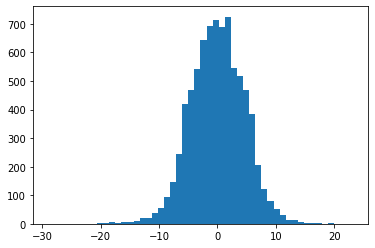

In [142]:
import matplotlib

matplotlib.pyplot.hist(x_values, bins=50)


(array([  1.,   0.,   3.,   0.,   4.,   1.,   7.,  10.,  10.,  20.,  15.,
         31.,  49.,  53.,  91., 128., 224., 326., 400., 485., 544., 591.,
        634., 666., 660., 572., 535., 473., 361., 430., 239., 116., 101.,
         54.,  48.,  33.,  27.,  20.,  14.,   2.,   6.,   7.,   2.,   1.,
          2.,   1.,   0.,   1.,   0.,   1.]),
 array([-21.99437341, -21.06155948, -20.12874555, -19.19593163,
        -18.2631177 , -17.33030377, -16.39748984, -15.46467592,
        -14.53186199, -13.59904806, -12.66623414, -11.73342021,
        -10.80060628,  -9.86779235,  -8.93497843,  -8.0021645 ,
         -7.06935057,  -6.13653665,  -5.20372272,  -4.27090879,
         -3.33809486,  -2.40528094,  -1.47246701,  -0.53965308,
          0.39316084,   1.32597477,   2.2587887 ,   3.19160263,
          4.12441655,   5.05723048,   5.99004441,   6.92285833,
          7.85567226,   8.78848619,   9.72130012,  10.65411404,
         11.58692797,  12.5197419 ,  13.45255582,  14.38536975,
         15.318183

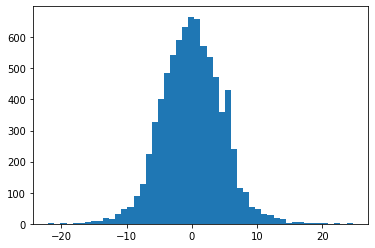

In [143]:
matplotlib.pyplot.hist(y_values, bins=50)

(array([  4.,   5.,   2.,   9.,   9.,  19.,  25.,  27.,  28.,  51.,  47.,
         82., 108., 136., 197., 252., 266., 320., 404., 449., 444., 492.,
        561., 541., 466., 490., 507., 413., 320., 313., 280., 207., 171.,
        126.,  90.,  52.,  37.,  17.,   9.,   7.,   6.,   4.,   2.,   2.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([-5.28209759e+01, -5.05258103e+01, -4.82306447e+01, -4.59354792e+01,
        -4.36403136e+01, -4.13451480e+01, -3.90499825e+01, -3.67548169e+01,
        -3.44596513e+01, -3.21644857e+01, -2.98693202e+01, -2.75741546e+01,
        -2.52789890e+01, -2.29838235e+01, -2.06886579e+01, -1.83934923e+01,
        -1.60983268e+01, -1.38031612e+01, -1.15079956e+01, -9.21283006e+00,
        -6.91766449e+00, -4.62249892e+00, -2.32733335e+00, -3.21677821e-02,
         2.26299779e+00,  4.55816336e+00,  6.85332892e+00,  9.14849449e+00,
         1.14436601e+01,  1.37388256e+01,  1.60339912e+01,  1.83291568e+01,
         2.06243223e+01,  2.29194879e+01,  2.52146

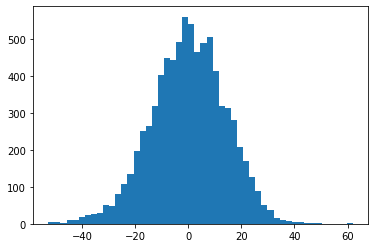

In [144]:
matplotlib.pyplot.hist(z_values, bins=50)

(array([182., 163., 173., 177., 167., 184., 174., 159., 191., 154., 194.,
        155., 171., 178., 136., 145., 139., 118., 151., 176., 147., 143.,
        152., 126., 124., 160., 150., 129., 138., 127., 184., 144., 149.,
        143., 134., 166., 150., 163., 171., 153., 162., 167., 179., 172.,
        175., 179., 185., 194., 169., 177.]),
 array([-9.99880113e-01, -9.59887155e-01, -9.19894197e-01, -8.79901239e-01,
        -8.39908280e-01, -7.99915322e-01, -7.59922364e-01, -7.19929406e-01,
        -6.79936447e-01, -6.39943489e-01, -5.99950531e-01, -5.59957573e-01,
        -5.19964614e-01, -4.79971656e-01, -4.39978698e-01, -3.99985740e-01,
        -3.59992781e-01, -3.19999823e-01, -2.80006865e-01, -2.40013907e-01,
        -2.00020948e-01, -1.60027990e-01, -1.20035032e-01, -8.00420735e-02,
        -4.00491153e-02, -5.61569968e-05,  3.99368013e-02,  7.99297595e-02,
         1.19922718e-01,  1.59915676e-01,  1.99908634e-01,  2.39901593e-01,
         2.79894551e-01,  3.19887509e-01,  3.59880

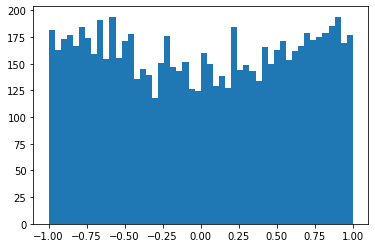

In [145]:
matplotlib.pyplot.hist(dir_x, bins=50)


(array([230., 182., 184., 180., 157., 172., 186., 161., 157., 141., 180.,
        183., 143., 162., 151., 170., 117., 158., 154., 124., 132., 139.,
        126., 143., 139., 128., 123., 157., 158., 127., 173., 160., 160.,
        180., 132., 164., 158., 152., 146., 167., 163., 170., 187., 156.,
        154., 178., 180., 185., 181., 189.]),
 array([-9.99848151e-01, -9.59852471e-01, -9.19856792e-01, -8.79861112e-01,
        -8.39865432e-01, -7.99869753e-01, -7.59874073e-01, -7.19878393e-01,
        -6.79882714e-01, -6.39887034e-01, -5.99891354e-01, -5.59895675e-01,
        -5.19899995e-01, -4.79904316e-01, -4.39908636e-01, -3.99912956e-01,
        -3.59917277e-01, -3.19921597e-01, -2.79925917e-01, -2.39930238e-01,
        -1.99934558e-01, -1.59938878e-01, -1.19943199e-01, -7.99475192e-02,
        -3.99518396e-02,  4.38400629e-05,  4.00395197e-02,  8.00351993e-02,
         1.20030879e-01,  1.60026559e-01,  2.00022238e-01,  2.40017918e-01,
         2.80013598e-01,  3.20009277e-01,  3.60004

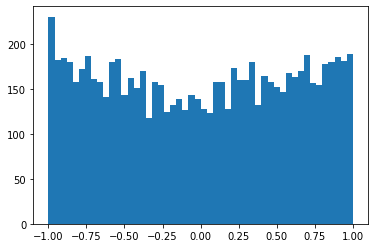

In [146]:
matplotlib.pyplot.hist(dir_y, bins=50)


(array([ 89., 104., 109., 119., 149., 143., 124., 150., 152., 131., 161.,
        171., 168., 210., 173., 182., 156., 188., 180., 180., 176., 173.,
        194., 188., 192., 175., 215., 198., 189., 184., 205., 159., 165.,
        152., 178., 169., 162., 193., 176., 178., 169., 177., 150., 156.,
        158., 125., 109., 116., 111.,  68.]),
 array([-9.97488057e-01, -9.57562349e-01, -9.17636640e-01, -8.77710932e-01,
        -8.37785223e-01, -7.97859515e-01, -7.57933806e-01, -7.18008098e-01,
        -6.78082389e-01, -6.38156680e-01, -5.98230972e-01, -5.58305263e-01,
        -5.18379555e-01, -4.78453846e-01, -4.38528138e-01, -3.98602429e-01,
        -3.58676721e-01, -3.18751012e-01, -2.78825304e-01, -2.38899595e-01,
        -1.98973887e-01, -1.59048178e-01, -1.19122470e-01, -7.91967613e-02,
        -3.92710528e-02,  6.54655693e-04,  4.05803642e-02,  8.05060727e-02,
         1.20431781e-01,  1.60357490e-01,  2.00283198e-01,  2.40208907e-01,
         2.80134615e-01,  3.20060324e-01,  3.59986

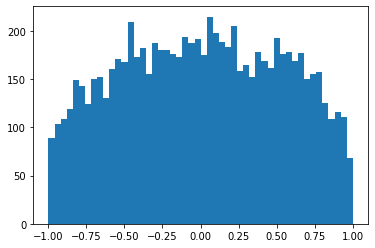

In [147]:
matplotlib.pyplot.hist(dir_z, bins=50)

In [98]:

difference = (k_effective_exp[-1] - 1.) * 100000
k_effective_std = get_std(k_effective)
standart_deviation = k_effective_std * 100000
print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))

 difference from beachmark [pcm]  -198.36239388205667  with standart deviation [pcm]+- 199.13559737842894


In [895]:
def save_simulation_results_to_file(k_effective, file_name):
    
    f = open(file_name, "w")
    
    for i in range(0, len(k_effective)):
        f.write(" cycle k effective "+ str(k_effective[i]) + '\n')
            
    
    f.close()


# In[58]:


file_name = "output"
save_simulation_results_to_file(k_effective, file_name)

In [153]:
k_effective, k_effective_exp, k_effective_std, estimators_result, result_particles_1 = simulation_black_boundaries(U235_Reactor,  
                           test_number_interations,  test_number_inactive, 
                          test_number_of_particles, u235, estimators)


 num1  4
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
i == 52
 keff_cycle , k_effective_exp, std_k_effective 0.9807918278759217   0.9684208781869301  0.012370949688991495
i == 53
 keff_cycle , k_effective_exp, std_k_effective 0.9731645045157272   0.9700020869631958  0.007315304955820994
i == 54
 keff_cycle , k_effective_exp, std_k_effective 0.9673384014065411   0.9693361655740321  0.0052153901670800515
i == 55
 keff_cycle , k_effective_exp, std_k_effective 0.967807679596072   0.9690304683784401  0.004051373536508083
i == 56
 keff_cycle , k_effective_exp, std_k_effective 0.9453257180221433   0.9650796766523907  0.005152783094357813


KeyboardInterrupt: 

In [125]:
x_values1 = []
y_values1 = []
z_values1 = []

dir_x1 = []
dir_y1 = []
dir_z1 = []

In [126]:
for i in range(0, len(result_particles_1)):
    x_values1.append(result_particles_1[i].coordinates.x)
    y_values1.append(result_particles_1[i].coordinates.y)
    z_values1.append(result_particles_1[i].coordinates.z)
    
    dir_x1.append(result_particles_1[i].direction.tetta_x)
    dir_y1.append(result_particles_1[i].direction.tetta_y)
    dir_z1.append(result_particles_1[i].direction.tetta_z)

(array([  1.,   2.,   2.,   4.,   4.,   1.,   4.,   9.,  10.,  22.,  30.,
         51.,  76., 141., 201., 404., 403., 481., 558., 601., 628., 647.,
        629., 583., 521., 473., 449., 289., 156., 107.,  72.,  26.,  31.,
         19.,  12.,   5.,   5.,   5.,   3.,   1.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-22.3068607 , -21.25386245, -20.2008642 , -19.14786595,
        -18.09486769, -17.04186944, -15.98887119, -14.93587293,
        -13.88287468, -12.82987643, -11.77687817, -10.72387992,
         -9.67088167,  -8.61788342,  -7.56488516,  -6.51188691,
         -5.45888866,  -4.4058904 ,  -3.35289215,  -2.2998939 ,
         -1.24689564,  -0.19389739,   0.85910086,   1.91209912,
          2.96509737,   4.01809562,   5.07109387,   6.12409213,
          7.17709038,   8.23008863,   9.28308689,  10.33608514,
         11.38908339,  12.44208165,  13.4950799 ,  14.54807815,
         15.6010764 ,  16.65407466,  17.70707291,  18.76007116,
         19.813069

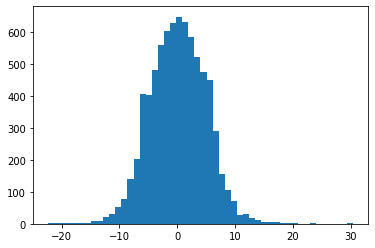

In [136]:
matplotlib.pyplot.hist(x_values1, bins=50)

(array([  1.,   3.,   1.,   2.,   1.,   4.,   3.,   2.,   8.,  10.,  15.,
         25.,  30.,  36.,  63., 113., 180., 268., 369., 397., 471., 471.,
        545., 547., 597., 571., 549., 476., 455., 354., 375., 256., 140.,
        113.,  76.,  45.,  22.,  23.,  14.,  10.,   4.,   7.,   3.,   2.,
          2.,   5.,   2.,   0.,   1.,   2.]),
 array([-22.31096135, -21.39874358, -20.48652581, -19.57430803,
        -18.66209026, -17.74987249, -16.83765472, -15.92543695,
        -15.01321918, -14.10100141, -13.18878363, -12.27656586,
        -11.36434809, -10.45213032,  -9.53991255,  -8.62769478,
         -7.71547701,  -6.80325924,  -5.89104146,  -4.97882369,
         -4.06660592,  -3.15438815,  -2.24217038,  -1.32995261,
         -0.41773484,   0.49448294,   1.40670071,   2.31891848,
          3.23113625,   4.14335402,   5.05557179,   5.96778956,
          6.88000733,   7.79222511,   8.70444288,   9.61666065,
         10.52887842,  11.44109619,  12.35331396,  13.26553173,
         14.177749

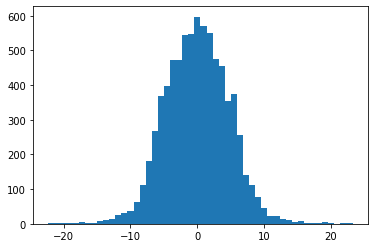

In [137]:
matplotlib.pyplot.hist(y_values1, bins=50)

(array([  1.,   0.,   1.,   1.,   3.,   6.,   5.,  10.,  28.,  36.,  40.,
         55.,  70.,  87.,  96., 124., 136., 167., 230., 238., 310., 371.,
        419., 434., 469., 454., 515., 443., 466., 398., 359., 305., 275.,
        232., 205., 137.,  93., 110.,  78.,  51.,  61.,  47.,  36.,  20.,
         17.,  13.,   3.,  10.,   1.,   3.]),
 array([-59.71118894, -57.41763258, -55.12407623, -52.83051987,
        -50.53696351, -48.24340716, -45.9498508 , -43.65629444,
        -41.36273808, -39.06918173, -36.77562537, -34.48206901,
        -32.18851266, -29.8949563 , -27.60139994, -25.30784358,
        -23.01428723, -20.72073087, -18.42717451, -16.13361816,
        -13.8400618 , -11.54650544,  -9.25294909,  -6.95939273,
         -4.66583637,  -2.37228001,  -0.07872366,   2.2148327 ,
          4.50838906,   6.80194541,   9.09550177,  11.38905813,
         13.68261449,  15.97617084,  18.2697272 ,  20.56328356,
         22.85683991,  25.15039627,  27.44395263,  29.73750898,
         32.031065

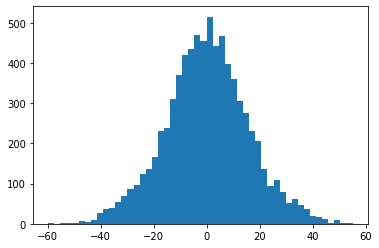

In [138]:
matplotlib.pyplot.hist(z_values1, bins=50)

(array([159., 189., 176., 183., 165., 159., 152., 153., 138., 169., 152.,
        163., 151., 138., 153., 128., 140., 136., 125., 128., 123., 139.,
        156., 131., 130., 125., 124., 146., 160., 131., 129., 134., 142.,
        141., 162., 153., 127., 176., 166., 125., 149., 186., 163., 179.,
        167., 197., 178., 206., 192., 175.]),
 array([-9.99883029e-01, -9.59888947e-01, -9.19894864e-01, -8.79900782e-01,
        -8.39906700e-01, -7.99912618e-01, -7.59918535e-01, -7.19924453e-01,
        -6.79930371e-01, -6.39936288e-01, -5.99942206e-01, -5.59948124e-01,
        -5.19954042e-01, -4.79959959e-01, -4.39965877e-01, -3.99971795e-01,
        -3.59977712e-01, -3.19983630e-01, -2.79989548e-01, -2.39995466e-01,
        -2.00001383e-01, -1.60007301e-01, -1.20013219e-01, -8.00191365e-02,
        -4.00250542e-02, -3.09719540e-05,  3.99631103e-02,  7.99571926e-02,
         1.19951275e-01,  1.59945357e-01,  1.99939439e-01,  2.39933522e-01,
         2.79927604e-01,  3.19921686e-01,  3.59915

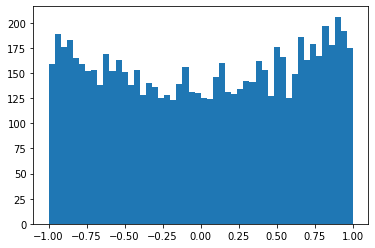

In [139]:
matplotlib.pyplot.hist(dir_x1, bins=50)

(array([164., 180., 171., 159., 174., 164., 152., 179., 153., 181., 133.,
        138., 167., 151., 190., 132., 151., 139., 120., 128., 163., 142.,
        140., 144., 115., 136., 141., 146., 153., 163., 112., 138., 162.,
        154., 136., 156., 157., 166., 153., 152., 122., 145., 160., 189.,
        164., 155., 155., 190., 151., 183.]),
 array([-9.99852542e-01, -9.59856364e-01, -9.19860187e-01, -8.79864009e-01,
        -8.39867832e-01, -7.99871655e-01, -7.59875477e-01, -7.19879300e-01,
        -6.79883123e-01, -6.39886945e-01, -5.99890768e-01, -5.59894590e-01,
        -5.19898413e-01, -4.79902236e-01, -4.39906058e-01, -3.99909881e-01,
        -3.59913704e-01, -3.19917526e-01, -2.79921349e-01, -2.39925171e-01,
        -1.99928994e-01, -1.59932817e-01, -1.19936639e-01, -7.99404619e-02,
        -3.99442845e-02,  5.18928534e-05,  4.00480702e-02,  8.00442476e-02,
         1.20040425e-01,  1.60036602e-01,  2.00032780e-01,  2.40028957e-01,
         2.80025134e-01,  3.20021312e-01,  3.60017

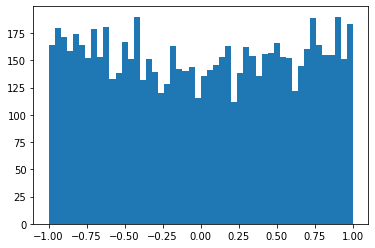

In [140]:
matplotlib.pyplot.hist(dir_y1, bins=50)

(array([ 75., 109., 116., 113., 131., 116., 122., 118., 177., 179., 139.,
        144., 120., 157., 192., 152., 194., 158., 167., 191., 189., 214.,
        181., 180., 153., 188., 214., 196., 164., 177., 177., 161., 167.,
        197., 153., 155., 175., 138., 157., 160., 148., 164., 159., 138.,
        141., 114., 118., 126., 102.,  93.]),
 array([-9.99151231e-01, -9.59170858e-01, -9.19190484e-01, -8.79210110e-01,
        -8.39229736e-01, -7.99249362e-01, -7.59268988e-01, -7.19288615e-01,
        -6.79308241e-01, -6.39327867e-01, -5.99347493e-01, -5.59367119e-01,
        -5.19386745e-01, -4.79406371e-01, -4.39425998e-01, -3.99445624e-01,
        -3.59465250e-01, -3.19484876e-01, -2.79504502e-01, -2.39524128e-01,
        -1.99543755e-01, -1.59563381e-01, -1.19583007e-01, -7.96026330e-02,
        -3.96222592e-02,  3.58114647e-04,  4.03384885e-02,  8.03188623e-02,
         1.20299236e-01,  1.60279610e-01,  2.00259984e-01,  2.40240358e-01,
         2.80220732e-01,  3.20201105e-01,  3.60181

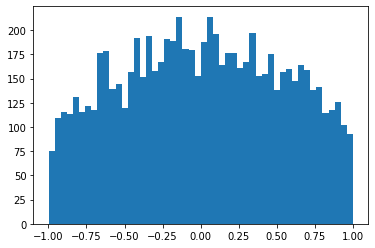

In [141]:
matplotlib.pyplot.hist(dir_z1, bins=50)